In [9]:
import tensorflow as tf
import numpy as np
import scipy.misc
import scipy.io
import matplotlib.pyplot as plt

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
content_image = scipy.misc.imread('1-content.jpg').astype(np.float)
style_image = scipy.misc.imread('1-style.jpg').astype(np.float)
style_image = scipy.misc.imresize(style_image, float(content_image.shape[1]) / style_image.shape[1])
def imsave(path, img):
    img = np.clip(img, 0, 255).astype(np.uint8)
    scipy.misc.imsave(path, img)

In [4]:
try:
    reduce
except NameError:
    from functools import reduce

In [5]:
def vgg_net(data_path, input_image):
    layers = (
        'conv1_1', 'relu1_1', 'conv1_2', 'relu1_2', 'pool1',

        'conv2_1', 'relu2_1', 'conv2_2', 'relu2_2', 'pool2',

        'conv3_1', 'relu3_1', 'conv3_2', 'relu3_2', 'conv3_3',
        'relu3_3', 'conv3_4', 'relu3_4', 'pool3',

        'conv4_1', 'relu4_1', 'conv4_2', 'relu4_2', 'conv4_3',
        'relu4_3', 'conv4_4', 'relu4_4', 'pool4',

        'conv5_1', 'relu5_1', 'conv5_2', 'relu5_2', 'conv5_3',
        'relu5_3', 'conv5_4', 'relu5_4'
    )

    data = scipy.io.loadmat(data_path)
    mean = data['normalization'][0][0][0]
    mean_pixel = np.mean(mean, axis=(0, 1))
    weights = data['layers'][0]

    net = {}
    current = input_image
    for i, name in enumerate(layers):
        kind = name[:4]
        if kind == 'conv':
            kernels, bias = weights[i][0][0][0][0]
            # matconvnet: weights are [width, height, in_channels, out_channels]
            # tensorflow: weights are [height, width, in_channels, out_channels]
            kernels = np.transpose(kernels, (1, 0, 2, 3))
            bias = bias.reshape(-1)
            current = _conv_layer(current, kernels, bias)
        elif kind == 'relu':
            current = tf.nn.relu(current)
        elif kind == 'pool':
            current = _pool_layer(current)
        net[name] = current

    assert len(net) == len(layers)
    return net, mean_pixel


def _conv_layer(input, weights, bias):
    conv = tf.nn.conv2d(input, tf.constant(weights), strides=(1, 1, 1, 1),
            padding='SAME')
    return tf.nn.bias_add(conv, bias)


def _pool_layer(input):
    return tf.nn.max_pool(input, ksize=(1, 2, 2, 1), strides=(1, 2, 2, 1),
            padding='SAME')


def preprocess(image, mean_pixel):
    return image - mean_pixel


def unprocess(image, mean_pixel):
    return image + mean_pixel

0
('Loss at step {}: {}', (0, 48726048.0))
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
('Loss at step {}: {}', (19, 4758535.5))
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
('Loss at step {}: {}', (38, 2544197.0))
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
('Loss at step {}: {}', (57, 2052960.9))
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
('Loss at step {}: {}', (76, 1629496.5))
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
('Loss at step {}: {}', (95, 1540256.8))
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
('Loss at step {}: {}', (114, 1396543.0))
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
('Loss at step {}: {}', (133, 1435553.5))
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
('Loss at step {}: {}', (152, 1329557.0))
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
('Loss at step {}: {}', (171, 1265920.9))
172
173


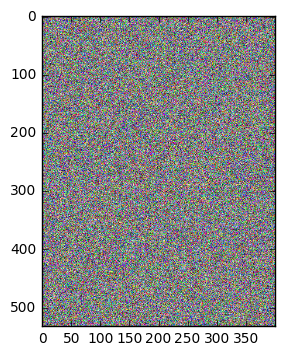

In [11]:
content_shape = (1,) + content_image.shape
style_shape = (1,) + style_image.shape
content_features = {}
style_features = {}
def _tensor_size(tensor):
    from operator import mul
    return reduce(mul, (d.value for d in tensor.get_shape()), 1)
CONTENT_LAYER = 'relu4_2'
STYLE_LAYERS = ('relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'relu5_1')

network = "imagenet-vgg-verydeep-19.mat"
g = tf.Graph()
with g.as_default(), g.device('/cpu:0'), tf.Session() as sess:
    image = tf.placeholder('float', shape=content_shape)
    net, mean_pixel = vgg_net(network, image)
    content_pre = np.array([preprocess(content_image, mean_pixel)])
    content_features[CONTENT_LAYER] = net[CONTENT_LAYER].eval(
            feed_dict={image: content_pre})
g = tf.Graph()
with g.as_default(), g.device('/cpu:0'), tf.Session() as sess:
    image = tf.placeholder('float', shape=style_shape)
    net, _ = vgg_net(network, image)
    style_pre = np.array([preprocess(style_image, mean_pixel)])
    for layer in STYLE_LAYERS:
        features = net[layer].eval(feed_dict={image: style_pre})
        features = np.reshape(features, (-1, features.shape[3]))
        gram = np.matmul(features.T, features) / features.size
        style_features[layer] = gram

CONTENT_WEIGHT = 5e0
STYLE_WEIGHT = 1e2
TV_WEIGHT = 1e2
LEARNING_RATE = 1e1
STYLE_SCALE = 1.0
ITERATIONS = 200
with tf.Graph().as_default():
    noise = np.random.normal(size=content_shape, scale=np.std(content_image) * 0.1)
    initial = tf.random_normal(content_shape) * 0.256 + noise
    image = tf.Variable(initial)
    net, _ = vgg_net(network, image)

    # content loss
    content_loss = CONTENT_WEIGHT * (2 * tf.nn.l2_loss(
            net[CONTENT_LAYER] - content_features[CONTENT_LAYER]) /
            content_features[CONTENT_LAYER].size)
    # style loss
    style_loss = 0
    for style_layer in STYLE_LAYERS:
        layer = net[style_layer]
        _, height, width, number = map(lambda i: i.value, layer.get_shape())
        size = height * width * number
        feats = tf.reshape(layer, (-1, number))
        gram = tf.matmul(tf.transpose(feats), feats) / size
        style_gram = style_features[style_layer]
        style_loss += STYLE_WEIGHT * 2 * tf.nn.l2_loss(gram - style_gram) / style_gram.size
    tv_y_size = _tensor_size(image[:,1:,:,:])
    tv_x_size = _tensor_size(image[:,:,1:,:])
    tv_loss = TV_WEIGHT * 2 * (
            (tf.nn.l2_loss(image[:,1:,:,:] - image[:,:content_shape[1]-1,:,:]) /
                tv_y_size) +
            (tf.nn.l2_loss(image[:,:,1:,:] - image[:,:,:content_shape[2]-1,:]) /
                tv_x_size))
    # overall loss
    loss = content_loss + style_loss + tv_loss

    # optimizer setup
    train_step = tf.train.AdamOptimizer(LEARNING_RATE).minimize(loss)
    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
        for i in range(ITERATIONS):
            train_step.run()
            print i
            if i % 19 == 0:
                this_loss = loss.eval()
                print("Loss at step {}: {}", (i, this_loss))
        best = image.eval()
        processed_image = unprocess(best.reshape(content_shape[1:]), mean_pixel)    
        plt.imshow(processed_image)
        plt.show()

In [13]:
imsave('output.jpg', processed_image)

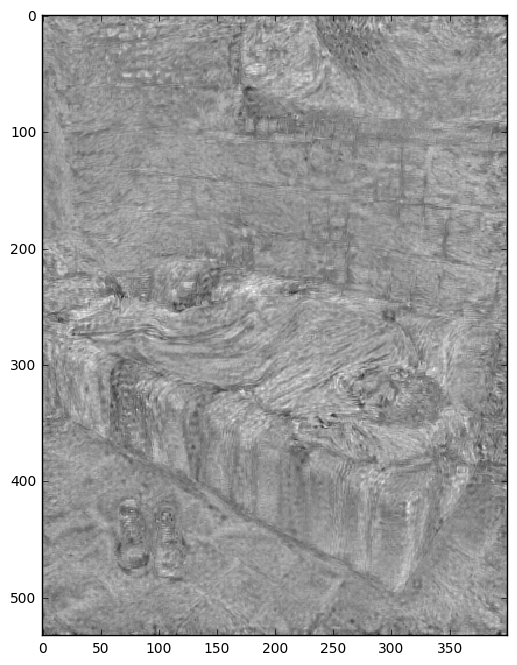

In [25]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots\n",
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

test_image = scipy.misc.imread('1-content.jpg').astype(np.float)
plt.imshow(processed_image[:,:,2])
plt.show()